In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

In [ ]:
#!unzip "/content/drive/MyDrive/data/driver_dataset.zip" -d "/content/drive/MyDrive/data"

In [ ]:
labels = os.listdir("/content/drive/MyDrive/data/train")

In [ ]:
labels

['no_yawn', 'Open', 'Closed', 'yawn']

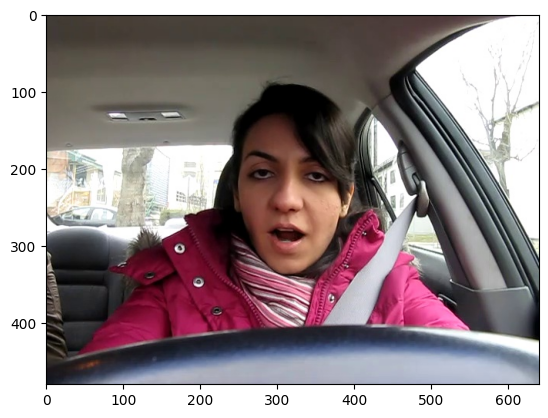

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("/content/drive/MyDrive/data/train/yawn/10.jpg"))

In [ ]:
def face_for_yawn(direc="/content/drive/MyDrive/data/train", face_cas_path="/content/drive/MyDrive/data/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [ ]:
def get_data(dir_path="/content/drive/MyDrive/data/train", face_cas="/content/drive/MyDrive/data/haarcascade_frontalface_default.xml", eye_cas="/content/drive/MyDrive/data/haarcascade_eye.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [ ]:
data_train = get_data()

2
3


In [ ]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [ ]:
new_data = append_data()

0
1
2
3


<ipython-input-10-be15ac3ad549>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
len(X_test)

578

In [ ]:
X_train=np.array(X_train)

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 23s 223ms/step - loss: 0.9454 - accuracy: 0.6036 - val_loss: 0.5349 - val_accuracy: 0.7353
Epoch 2/50
43/43 [==============================] - 10s 234ms/step - loss: 0.4874 - accuracy: 0.8025 - val_loss: 0.3788 - val_accuracy: 0.8322
Epoch 3/50
43/43 [==============================] - 8s 190ms/step - loss: 0.4002 - accuracy: 0.8434 - val_loss: 0.4214 - val_accuracy: 0.8391
Epoch 4/50
43/43 [==============================] - 11s 245ms/step - loss: 0.3296 - accuracy: 0.8641 - val_loss: 0.2547 - val_accuracy: 0.8858
Epoch 5/50
43/43 [==============================] - 8s 180ms/step - loss: 0.3211 - accuracy: 0.8708 - val_loss: 0.2948 - val_accuracy: 0.8962
Epoch 6/50
43/43 [==============================] - 10s 218ms/step - loss: 0.3085 - accuracy: 0.8775 - val_loss: 0.2695 - val_accuracy: 0.8893
Epoch 7/50
43/43 [==============================] - 10s 238ms/step - loss: 0.2845 - accuracy: 0.8857 - val_loss: 0.2873 - val_accuracy: 0.8824
E

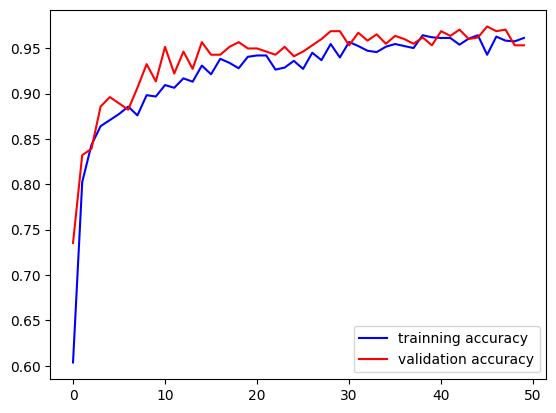

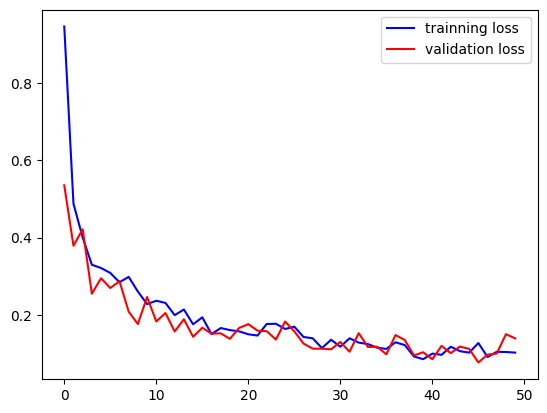

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/drowiness_new6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("/content/drive/MyDrive/drowiness_new6.model")

In [ ]:
predictions = model.predict(X_test)

# Convert the raw predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

19/19 [==============================] - 1s 34ms/step


In [ ]:
predicted_classes

array([3, 2, 2, 3, 1, 2, 2, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 0, 1, 3, 2, 3,
       2, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 2, 2, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 0, 3, 3, 3, 2, 1, 2, 3, 2, 2, 2, 0, 3, 2, 2, 2, 2, 0,
       3, 3, 2, 3, 3, 3, 2, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 2, 2, 3,
       1, 2, 2, 2, 1, 3, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 3, 3, 2, 0, 3, 3,
       1, 3, 1, 2, 3, 3, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3,
       2, 0, 1, 0, 3, 1, 3, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 1, 2, 1, 3, 2,
       2, 2, 0, 2, 3, 1, 2, 1, 3, 2, 3, 0, 2, 0, 1, 2, 3, 2, 3, 3, 3, 0,
       3, 2, 3, 1, 2, 0, 0, 2, 2, 3, 2, 2, 3, 1, 2, 2, 2, 2, 1, 3, 0, 2,
       1, 0, 2, 3, 3, 3, 2, 0, 1, 2, 1, 0, 2, 3, 1, 3, 3, 1, 3, 3, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 2, 3, 2, 2,
       3, 2, 2, 0, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 1, 2, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 1, 3, 2, 2, 1,

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have the true labels in y_test and the predicted classes in predicted_classes
true_labels = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(true_labels, predicted_classes, target_names=labels)

# Print the report
print(report)

              precision    recall  f1-score   support

     no_yawn       0.90      0.73      0.81        63
        Open       0.77      0.66      0.71        74
      Closed       0.81      0.99      0.89       215
        yawn       0.99      0.88      0.93       226

    accuracy                           0.88       578
   macro avg       0.87      0.81      0.83       578
weighted avg       0.88      0.88      0.87       578



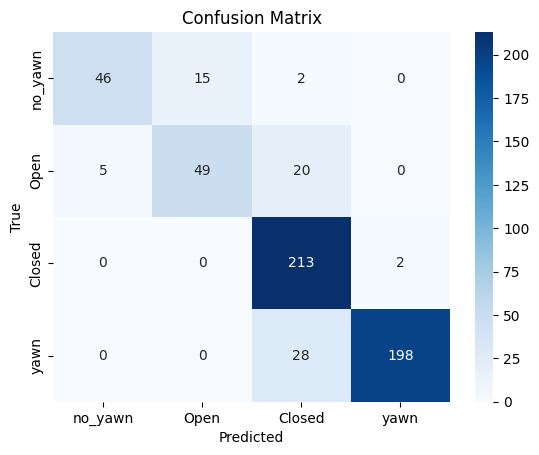

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the true labels in y_test and the predicted classes in predicted_classes
true_labels = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/drowiness_new6.h5")

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/data/train/no_yawn/1067.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 20ms/step


1

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/data/train/Closed/_101.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 29ms/step


2

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/data/train/Open/_104.jpg")])
np.argmax(prediction)


1/1 [==============================] - 0s 18ms/step


3

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/data/train/yawn/113.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 27ms/step


3

In [ ]:

prediction = model.predict([prepare("/content/drive/MyDrive/data/train/yawn/130.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 18ms/step


3

In [ ]:

prediction = model.predict([prepare("/content/drive/MyDrive/data/train/no_yawn/1030.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 68ms/step


0

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/data/train/no_yawn/1038.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 71ms/step


0

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/data/train/no_yawn/1050.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 25ms/step


2

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/data/train/no_yawn/113.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 73ms/step


2

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/data/train/no_yawn/115.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 67ms/step


2